# Praca z danymi

### Eksploracja danych jednowymiarowych

Jednowymiarowy zbiór danych jest po prostu ciągiem wartości. Przykładem dakich danych jest liczba minut spędzanych na stronie przez każdego z jej użytkowników, liczba określająca, ile razy zbiór materiałów wideo dotyczących danych został obejrzany, lub liczba stron każdej z książek wchodzących wskład biblioteczki.

In [1]:
from typing import List, Dict
from collections import Counter
import math

import matplotlib.pyplot as plt

def bucketize(point: float, bucket_size: float) -> float:
    """Przypisz punkt do następnej najniższej wielokrotności bucket_size."""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points: List[float], bucket_size: float) -> Dict[float, int]:
    """Dzieli punkty na grupy i liczy punkty umieszczone w poszczególnych grupach"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points: List[float], bucket_size: float, title: str = ""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)

In [2]:
# Odwrotność dystrybuanty rozkładu narmalnego
def inverse_normal_cdf(p: float,
                       mi: float = 0,
                       sigma: float = 1,
                       tolerance: float = 0.00001) -> float:
    """Znajduje przybliżoną wartość odwrotności przy użyciu algorytmu wyszukiwania binarnego."""

    # Jeżeli rozkład nie jest standardowy, to oblicz jego standardową postać i przeskaluj.
    if mi != 0 or sigma != 1:
        return mi + sigma * inverse_normal_cdf(p, tolerance=tolerance)

    low_z = -10.0                      # normal_cdf(-10) ma wartość (zbliżoną do) 0
    hi_z  =  10.0                      # normal_cdf(10)  ma wartość (zbliżoną do) 1
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2     # Weź pod uwagę punkt środkowy
        mid_p = normal_cdf(mid_z)      # i znajdującą się tam wartość dystrybuanty.
        if mid_p < p:
            low_z = mid_z              # Punkt środkowy znajduje się za nisko, szukaj nad nim.
        else:
            hi_z = mid_z               # Punkt środkowy znajduje się za wysoko, szukaj pod nim.

    return mid_z

# Dystrybuanta rozkładu

def normal_cdf(x: float, mi: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mi) / math.sqrt(2) / sigma)) / 2

In [3]:
# przykładowe zbiory danych
import random
random.seed(0)

# Rozkład jednostajny wartości od -100 do 100
uniform = [200 * random.random() - 100 for _ in range(10000)]

# Rozkład normalny o średniej 0 i odchyleniu standardowym równym 57.
normal = [57 * inverse_normal_cdf(random.random())
        for _ in range(10000)]

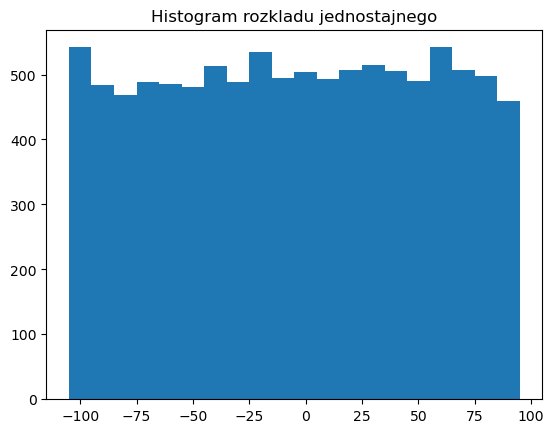

In [4]:
plot_histogram(uniform, 10, "Histogram rozkladu jednostajnego")

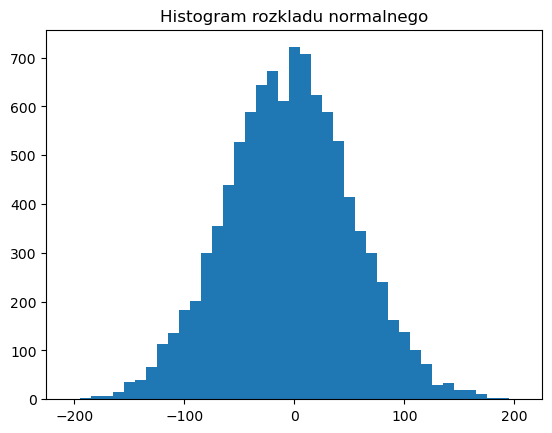

In [5]:
plot_histogram(normal, 10, "Histogram rozkladu normalnego")

### Dwa wymiary

Mamy dwuwymiarowy zbiór danych. Np. do liczby minut spędzanych przez użytkowników w serwisie dodaliśmy lata doświadczenia w pracy analityka.

In [6]:
def random_normal() -> float:
    """Zwraca liczbę wylosowaną z rozkładu normalnego."""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]

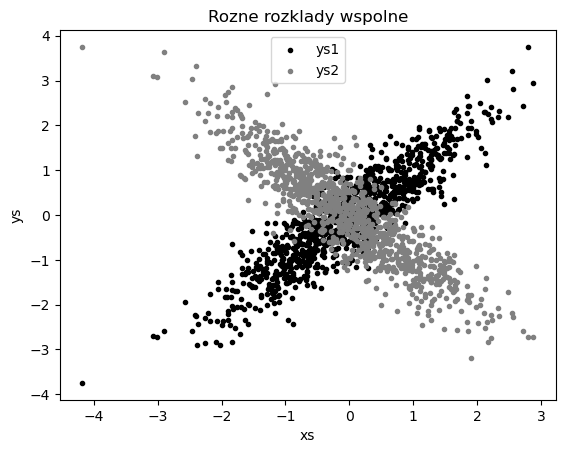

In [7]:
plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)
plt.title("Rozne rozklady wspolne")
plt.show()

Korelacja

In [8]:
Vector = List[float]

# Iloczyn skalarny
def dot(v: Vector, w: Vector) -> float:
    """Oblicza v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "wektory muszą mieć taką samą długość"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))


def sum_of_squares(v: Vector) -> float:
    """Returns v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

def mean(xs: List[float]) -> float:
    return sum(xs) / len(xs)

# Wariancja

def de_mean(xs: List[float]) -> List[float]:
    """Przekształca x poprzez odjęcie średniej."""
    x_bar = mean(xs)
    return [x - x_bar for x in xs]
def variance(xs: List[float]) -> float:
    """Prawie jak średnie odchylenie kwadratowe od średniej."""
    assert len(xs) >= 2, "wariancja wymaga co najmniej dwóch elementów"

    n = len(xs)
    deviations = de_mean(xs)
    return sum_of_squares(deviations) / (n - 1) 

# Odchylenie standardowe
import math

def standard_deviation(xs: List[float]) -> float:
    """Odchylenie standardowe jest pierwiastkiem kwadratowym wariancji."""
    return math.sqrt(variance(xs))

def covariance(xs: List[float], ys: List[float]) -> float:
    assert len(xs) == len(ys), "xs i ys muszą mieć taką samą liczbę elementów"

    return dot(de_mean(xs), de_mean(ys)) / (len(xs) - 1)

# Korelacja
def correlation(xs: List[float], ys: List[float]) -> float:
    """Mierzy, jak bardzo xs i ys różnią się łącznie od swoich średnich"""
    stdev_x = standard_deviation(xs)
    stdev_y = standard_deviation(ys)
    if stdev_x > 0 and stdev_y > 0:
        return covariance(xs, ys) / stdev_x / stdev_y
    else:
        return 0    # Przy braku wariancji korelacja jest zerowa.

In [9]:
print(correlation(xs, ys1)) #0.9
print(correlation(xs, ys2)) #-0.9

0.9010493686379609
-0.8920981526880033


### Wiele wymiarów

Macierz korelacji - element znajdujący sie w wierszu-i i kolumnie-j określa korelację pomiędzy i-tym i j-tym wymiarem zbioru danych.

In [10]:
from typing import List

Vector = List[float]

# alias typu macierzy
Matrix = List[List[float]]

# Tworzenie macierzy o określonych wymiarach, korzystając z funkcji generujacej elementy macierzy
from typing import Callable

def make_matrix(num_rows: int,
                num_cols: int,
                entry_fn: Callable[[int, int], float]) -> Matrix:
    """
    Zwraca macierz o wymiarach num_rows x num_cols, 
    której element (i, j) jest definiowany jako entry_fn(i, j).
    """
    return [[entry_fn(i, j)             # Na podstawie danego i utwórz listę
             for j in range(num_cols)]  # [entry_fn(i, 0), ... ]
            for i in range(num_rows)]   # Utwórz po jednej liście dla każdego i

In [11]:
def correlation_matrix(data: List[Vector]) -> Matrix:
    """
    Zwraca macierz o wymiarach len(data) × len(data), której element (i, j)
    określa korelację pomiędzy kolumnami i i j zbioru danych.
    """
    def correlation_ij(i: int, j: int) -> float:
        return correlation(data[i], data[j])

    return make_matrix(len(data), len(data), correlation_ij)

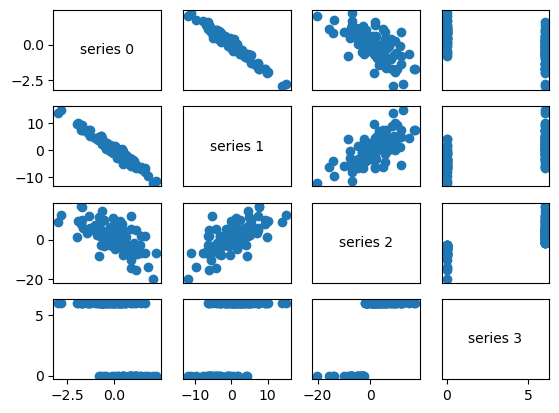

In [12]:
# Losowe dane w celu pokazania wykresów punktowych.
num_points = 100

def random_row() -> List[float]:
    row = [0.0, 0, 0, 0]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

random.seed(0)
# każdy rząd ma 4 punkty, ale tak naprawdę chcemy kolumn
corr_rows = [random_row() for _ in range(num_points)]

corr_data = [list(col) for col in zip(*corr_rows)]


# corr_data jest listą czterech 100-wymiarowych wektorów
num_vectors = len(corr_data)
fig, ax = plt.subplots(num_vectors, num_vectors)

for i in range(num_vectors):
    for j in range(num_vectors):

        # Wykres punktowy column_j (oś x) w zależności od column_i (oś y).
        if i != j: ax[i][j].scatter(corr_data[j], corr_data[i])

        # Jeżeli i == j, pokaż nazwę serii.
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                xycoords='axes fraction',
                                ha="center", va="center")

        # Ukryj etykiety osi poza wykresami znajdującymi się po lewej stronie i na dole.
        if i < num_vectors - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

# Popraw etykiety wykresów znajdujących się w dolnym prawym rogu i górnym lewym rogu.
# Są one nieprawidłowe, ponieważ wykresy te zawierają tylko tekst.
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

### Wykorzystanie klasy NamedTuple

Jednym z popularnych sposobów przechowywania danych są słowniki

In [13]:
import datetime

stock_price = {'closing_price': 102.06,
               'date': datetime.date(2014, 8, 29),
               'symbol': 'AAPL'}

Nie jest do jednak najlepsza metoda.

Poważną sprawą jest podatność na błędy przy dostępie do słownika za pomocą kluczy. Poniższy kod wykona się bez błędu, ale zadziała w nieodpowiedni sposób:

In [14]:
# uuups, literówka ('cosing' zamiast 'closing')
stock_price['cosing_price'] = 103.06

Możemy dodać adnotacje do słowników, które mają wartości tego samego typu

In [15]:
prices: Dict[datetime.date, float] = {}

Klasa namedtuple - obiekty zachowują się tak jak obiekt typu tuple, ale do poszczególnych elementów można uzyskać dostęp za pomocą nazwy pola

In [16]:
from collections import namedtuple

StockPrice = namedtuple('StockPrice', ['symbol', 'date', 'closing_price'])
price = StockPrice('MSFT', datetime.date(2018,12,14), 106.03)

In [17]:
price.symbol

'MSFT'

In [18]:
price.closing_price

106.03

Klasa namedtuple tak jak w przypadku krotek jest niemutowalna.

Adnotacja typów:

In [19]:
from typing import NamedTuple

class StockPrice(NamedTuple):
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """To jest klasa, więc możemy również dodawać funkcje"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price = StockPrice('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price.symbol == 'MSFT'
assert price.closing_price == 106.03
assert price.is_high_tech()

### Dekorator dataclass

Klasy utworzone przy użyciu dekoratora dataclass są czymś w rodzaju klasy NamedTuple, ale przechowywane przez nie wartości mogą być zmieniane.

In [20]:
from dataclasses import dataclass

@dataclass
class StockPrice2:
    symbol: str
    date: datetime.date
    closing_price: float

    def is_high_tech(self) -> bool:
        """To jest klasa, więc możemy również dodawać funkcje"""
        return self.symbol in ['MSFT', 'GOOG', 'FB', 'AMZN', 'AAPL']

price2 = StockPrice2('MSFT', datetime.date(2018, 12, 14), 106.03)

assert price2.symbol == 'MSFT'
assert price2.closing_price == 106.03
assert price2.is_high_tech()

In [21]:
# możemy znienić wartości
price2.closing_price /= 2
price2.closing_price

53.015

### Oczyszczanie i wstępne przetwarzanie danych

In [22]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

# Teraz testujemy naszą funkcję
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [23]:
from dateutil.parser import parse

def parse_row(row: List[str]) -> StockPrice:
    symbol, date, closing_price = row
    return StockPrice(symbol=symbol,
                      date=parse(date).date(),
                      closing_price=float(closing_price))

# Teraz testujemy naszą funkcję
stock = parse_row(["MSFT", "2018-12-14", "106.03"])

assert stock.symbol == "MSFT"
assert stock.date == datetime.date(2018, 12, 14)
assert stock.closing_price == 106.03

In [24]:
# W przypadku niepoprawnych danych lepiej wygenerować wartośc None niż zawiesić program

from typing import Optional
import re

def try_parse_row(row: List[str]) -> Optional[StockPrice]:
    symbol, date_, closing_price_ = row

    # Oznaczenia akcji giełdowych powinny być zapisane dużymi literami
    if not re.match(r"^[A-Z]+$", symbol):
        return None

    try:
        date = parse(date_).date()
    except ValueError:
        return None

    try:
        closing_price = float(closing_price_)
    except ValueError:
        return None

    return StockPrice(symbol, date, closing_price)

# Powinniśmy dostać None w przypadku błędów
assert try_parse_row(["MSFT0", "2018-12-14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12--14", "106.03"]) is None
assert try_parse_row(["MSFT", "2018-12-14", "x"]) is None

# Ale funkcja powinna zwrócić to co wcześniej, jeżeli dane są poprawne
assert try_parse_row(["MSFT", "2018-12-14", "106.03"]) == stock

In [25]:
# zwrócone tylko prawidłowe wartości
import csv

data: List[StockPrice] = []

with open("comma_delimited_stock_prices.csv") as f:
    reader = csv.reader(f)
    for row in reader:
        maybe_stock = try_parse_row(row)
        if maybe_stock is None:
            print(f"Pominięty nieprawidłowy rekord: {row}")
        else:
            data.append(maybe_stock)

Pominięty nieprawidłowy rekord: ['MSFT', '6/19/2014', 'n/a']


### Przeskalowanie

Załóżmy, że dysponujemy zbiorem danych zawierającym informacje o wzroście i wadze setek analityków. Chcemy zidentyfikować grupy "rozmiarów ciał" analityków.

    Osoba           Wzrost(cale)               Wzrost(centymetry)         Waga(kilogramy)
    A                 63                            160                    70
    B                 67                            170,2                  78
    C                 70                            177,8                  88

In [26]:
# Odejmowanie wektorów
def subtract(v: Vector, w: Vector) -> Vector:
    """odejmowanie wektorów"""
    assert len(v) == len(w), "wektory muszą mieć tę samą długość "

    return [v_i - w_i for v_i, w_i in zip(v, w)]

# Moduł wektora
import math

def magnitude(v: Vector) -> float:
    """Zwraca moduł (długość) wektora v"""
    return math.sqrt(sum_of_squares(v))   # Funkcja math.sqrt oblicza wartość pierwiastka kwadratowego.

# Odległości pomiędzy dwoma wektorami
def squared_distance(v: Vector, w: Vector) -> float:
    """Oblicza (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

def distance(v: Vector, w: Vector) -> float:
    """Oblicza odległość pomiędzy v i w"""
    return math.sqrt(squared_distance(v, w))


def distance(v: Vector, w: Vector) -> float:  # type: ignore
    return magnitude(subtract(v, w))

In [27]:
a_to_b = distance([63, 150], [67, 160])
a_to_b

10.770329614269007

In [28]:
a_to_c = distance([63, 150], [70, 171]) 
a_to_c 

22.135943621178654

In [29]:
b_to_c = distance([67, 160], [70, 171]) 
b_to_c

11.40175425099138

In [30]:
a_to_b = distance([160, 150], [170.2, 160])
a_to_b

14.284257068535268

In [31]:
a_to_c = distance([160, 150], [177.8, 171])  
a_to_c 

27.52889391167034

In [32]:
b_to_c = distance([170.2, 160], [177.8, 171]) 
b_to_c 

13.370115930686627

Gdy nie można porównać ze sobą wymiarów, stosowana jest technika skalowania danych tak, aby wartości każdego z wymiarów charakteryzowały się średnią równą 0 i odchyleniem standardowym równym 1. W ten sposób pozbędziemy się jednostek, a wartości każdego z wymiarów będą określały "odchylenia standardowe od średniej".

In [33]:
from typing import Tuple

# Mnożenie wektora przez skalar
def scalar_multiply(c: float, v: Vector) -> Vector:
    """Mnoży każdy element przez c"""
    return [c * v_i for v_i in v]

# Średnia wektorów o tych samych wymiarach
def vector_mean(vectors: List[Vector]) -> Vector:
    """Oblicza wektor, którego i-ty element jest średnią i-tych elementów wektorów wejściowych."""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

# Odchylenie standardowe
import math

def standard_deviation(xs: List[float]) -> float:
    """Odchylenie standardowe jest pierwiastkiem kwadratowym wariancji."""
    return math.sqrt(variance(xs))

# utworzenie nowego wektora, którego pierwszy element jest sumą pierwszych elementów wszystkich wektorów, drugi drugich itd.
def vector_sum(vectors: List[Vector]) -> Vector:
    """Sumuje listę wektorów"""
    # Sprawdzenie, czy lista wektorów nie jest pusta
    assert vectors, "brak wektorów!"

    # Sprawdzenie, czy wszystkie wektory mają taką samą długość
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "różne długości!"

    # i-ty element wektora wynikowego jest sumą elementów [i] każdego wektora
    return [sum(vector[i] for vector in vectors)
            for i in range(num_elements)]



def scale(data: List[Vector]) -> Tuple[Vector, Vector]:
    """Zwraca średnie i odchylenia standardowe poszczególnych kolumn."""
    dim = len(data[0])

    means = vector_mean(data)
    stdevs = [standard_deviation([vector[i] for vector in data])
              for i in range(dim)]

    return means, stdevs

vectors = [[-3, -1, 1], [-1, 0, 1], [1, 1, 1]]
means, stdevs = scale(vectors)

In [34]:
means 

[-1.0, 0.0, 1.0]

In [35]:
stdevs

[2.0, 1.0, 0.0]

In [36]:
# macierz z nowymi wartościami
def rescale(data: List[Vector]) -> List[Vector]:
    """
    Przeskalowuje dane wejściowe tak, aby każda kolumna charakteryzowała się średnią równą 0
    i odchyleniem standardowym równym 1. Kolumny bez odchylenia są ignorowane
    """
    dim = len(data[0])
    means, stdevs = scale(data)

    # Tworzymy kopię każdego wektora
    rescaled = [v[:] for v in data]

    for v in rescaled:
        for i in range(dim):
            if stdevs[i] > 0:
                v[i] = (v[i] - means[i]) / stdevs[i]

    return rescaled

means, stdevs = scale(rescale(vectors))

In [37]:
means 

[0.0, 0.0, 1.0]

In [38]:
stdevs 

[1.0, 1.0, 0.0]

### Dygrasja: tqdm

Biblioteka tqdm umożliwia wyświetlenie pasków postępu.

Najpierw należy ją zainstalować: python -m pip install tqdm

In [39]:
import tqdm

In [40]:
for i in tqdm.tqdm(range(100)):
    #zrób coś, co zajmuje dużo czasu
    _ = [random.random() for _ in range(1000000)]

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.87it/s]


In [41]:
# można też dodać opis wyświetlany razem z paskiem postępu
from typing import List

def primes_up_to(n: int) -> List[int]:
    primes = [2]

    with tqdm.trange(3, n) as t:
        for i in t:
            # i jest liczbą pierwszą, jeżeli nie dzieli się przez żadną mniejszą liczbę pierwszą
            i_is_prime = not any(i % p == 0 for p in primes)
            if i_is_prime:
                primes.append(i)

            t.set_description(f"{len(primes)} primes")

    return primes

my_primes = primes_up_to(100_000)

9371 primes:  97%|████████████████████████████████████████████████████████████▍ | 97427/99997 [05:35<00:11, 223.89it/s]

### Redukcja liczby wymiarów

Czasami wymiary danych nie pokrywają się z wymiarami, które mamy zdefiniowane w danych.

Najpierw przekształcamy dane tak, aby każdy z wymiarów charakteryzował sie średnią równą zero

In [42]:
# Odejmowanie wektorów
def subtract(v: Vector, w: Vector) -> Vector:
    """odejmowanie wektorów"""
    assert len(v) == len(w), "wektory muszą mieć tę samą długość "

    return [v_i - w_i for v_i, w_i in zip(v, w)]

In [43]:
def de_mean(data: List[Vector]) -> List[Vector]:
    """Przekształca dane tak, aby w każdym wymiarze miały średnią 0."""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

Dysponując przetworzoną macierzą X, możemy określić kierunek, który najbardziej oddaje zmienność danych.

Jeśli mamy dany kierunek d (wektor o wartości bezwzględnej równej 1), to każdy wiersz x w macierzy przedłuża dot(x,d) w kierunku d, a każdy wektor w określi kierunek, gdybyśmy go przeskalowali tak, aby charakteryzował się wartością bezwzgledną równą 1:

In [44]:
# Moduł wektora
import math

def magnitude(v: Vector) -> float:
    """Zwraca moduł (długość) wektora v"""
    return math.sqrt(sum_of_squares(v))   # Funkcja math.sqrt oblicza wartość pierwiastka kwadratowego.

In [45]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

Dysponując niezerowym wektorem w, możemy obliczyć wariancję zbioru danych w kierunku wektora w

In [46]:
# Iloczyn skalarny
def dot(v: Vector, w: Vector) -> float:
    """Oblicza v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w), "wektory muszą mieć taką samą długość"

    return sum(v_i * w_i for v_i, w_i in zip(v, w))

In [47]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """Wariancja danych w kierunku w."""
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

Chcemy znaleźć kierunek maksymalizujący te wariancję. Możemy to zrobić za pomocą metody gradientu prostego po utworzeniu funkcji obliczającej gradient

In [48]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """
   Gradient wariancji kierunkowej względem w.
    """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

Pierwszą główną składową jest kierunek maksymalizujący wartość funkcji directional_variance

In [49]:
def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """Przejdź o step_size w kierunku gradient od punktu v."""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

In [50]:
def first_principal_component(data: List[Vector],
                              n: int = 100,
                              step_size: float = 0.1) -> Vector:
    # Rozpocznij od wartości losowej
    guess = [1.0 for _ in data[0]]

    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")

    return direction(guess)

Po określeniu kierunku możemy wykonać operację rzutowania na niego danych w celu określenia wartości tej składowej

In [51]:
# Mnożenie wektora przez skalar
def scalar_multiply(c: float, v: Vector) -> Vector:
    """Mnoży każdy element przez c"""
    return [c * v_i for v_i in v]

In [52]:
def project(v: Vector, w: Vector) -> Vector:
    """Zwraca wynik rzutowania wektora v w kierunku w."""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

W celu znalezienia kolejnyc składowych musimy  usunąć rzutowania z danych

In [53]:
# Odejmowanie wektorów
def subtract(v: Vector, w: Vector) -> Vector:
    """odejmowanie wektorów"""
    assert len(v) == len(w), "wektory muszą mieć tę samą długość "

    return [v_i - w_i for v_i, w_i in zip(v, w)]

In [54]:
def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """Rzutuje wektor v na w i odejmuje uzyskany wynik od wektora v."""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

W przypadku zbioru danych zawierającego więcej wymiarów moglibyśmy w ten sposób iteracyjnie ustalić większą liczbę składowych

In [55]:
def pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)

    return components

Przekształcenie danych mające na celu uzyskanie przestrzeni o mniejszej liczbie wymiarów rozłożonych na przestrzeni głównych składowych:

In [56]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]